## Imports

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [58]:
df = pd.read_csv('train.csv')
df.dropna(subset=['value_eur'], inplace=True)
df = df[~df["player_positions"].str.contains("GK", na=False)]

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13610 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   13610 non-null  int64  
 1   id                           13610 non-null  int64  
 2   short_name                   13610 non-null  object 
 3   long_name                    13610 non-null  object 
 4   player_positions             13610 non-null  object 
 5   overall                      13610 non-null  int64  
 6   potential                    13610 non-null  int64  
 7   value_eur                    13610 non-null  float64
 8   wage_eur                     13610 non-null  float64
 9   age                          13610 non-null  int64  
 10  dob                          13610 non-null  object 
 11  height_cm                    13610 non-null  int64  
 12  weight_kg                    13610 non-null  int64  
 13  club_team_id         

## Drop irrelevant columns

In [60]:
cols_to_drop = ['Unnamed: 0', 'id', 'short_name', "long_name", "dob", "club_jersey_number", "nation_jersey_number", "club_id", "club_loaned_from", "nation_position", "player_traits", "player_tags", "nationality_name", "club_team_id", "nationality_id"]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

## Contract-related variable manipulation

In [61]:
start_date = float(2021) # year when dataset was recorded 
df["years_left_contract"] = df["club_contract_valid_until"] - start_date

df['club_joined'] = pd.to_datetime(df['club_joined'], format='%Y-%m-%d')
df["years_in_club"] = start_date - df["club_joined"].dt.year

In [62]:
df.drop(columns=["club_contract_valid_until", "club_joined"], inplace=True, errors='ignore')

## Work rate split

In [63]:
df[["work_attack", "work_defense"]] = df["work_rate"].str.split("/", expand=True)
maps = {"Low": 1, "Medium": 2, "High": 3}
df["work_attack"] = df["work_attack"].map(maps)
df["work_defense"] = df["work_defense"].map(maps)

## Target-based ordinal encoding for postions

In [64]:
df[["primary_position", "secondary_position", "tertiary_position"]] = df["player_positions"].str.split(",", expand=True)

In [65]:
df[["primary_position", "secondary_position", "tertiary_position"]] = df["player_positions"].str.split(", ", expand=True)

In [66]:
club_position_map = df.groupby('club_position')['value_eur'].median().sort_values().rank().to_dict()
club_position_map[None] = 0
df["club_position"] = df["club_position"].map(club_position_map)
df["primary_position"] = df["primary_position"].map(club_position_map)
df["secondary_position"] = df["secondary_position"].map(club_position_map)
df["tertiary_position"] = df["tertiary_position"].map(club_position_map)

df["is_multiposition"] = df["player_positions"].apply(lambda x: len(x.split(",")) > 1).astype(int)
df.drop(columns=["player_positions"], inplace=True, errors='ignore')

## Grouping Technical Attributes

In [67]:
#Attacking attributes score
df["attacking_score"] = df[[
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "attacking_volleys"
]].mean(axis=1)

In [68]:
#Skills attributes score
df["skills_score"] = df[[
    "skill_dribbling",
    "skill_curve",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control"
]].mean(axis=1)

In [69]:
# Movement attributes score
df["movement_score"] = df[[
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_agility",
    "movement_reactions",
    "movement_balance"
]].mean(axis=1)

In [70]:
# Power attributes score
df["power_score"] = df[[
    "power_shot_power",
    "power_jumping",
    "power_stamina",
    "power_strength",
    "power_long_shots"
]].mean(axis=1)

In [71]:
# Mentality attributes score
df["mentality_score"] = df[[
    "mentality_aggression",
    "mentality_interceptions",
    "mentality_positioning",
    "mentality_vision",
    "mentality_penalties",
    "mentality_composure"
]].mean(axis=1)

In [72]:
# Defending technical attributes score
df["defending_technical_score"] = df[[
    "defending_marking_awareness",
    "defending_standing_tackle",
    "defending_sliding_tackle"
]].mean(axis=1)

## Starter bool

In [73]:
df["is_starter"] = (~df["club_position"].isin(["SUB", "RES"])).astype(int)

## Handle Missing Data

In [74]:
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    df[col] = df[col].astype('category')

In [75]:
df["overall_potential"] = df["overall"] * df["potential"]

## Target based ordinal encoding for club and league

In [76]:
club_map = df.groupby('club_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["club_name"] = df["club_name"].map(club_map)

league_map = df.groupby('league_name', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["league_name"] = df["league_name"].map(league_map)

## Target based ordinal encoding for work_rate

In [77]:
work_rate_map = df.groupby('work_rate', observed=True)['value_eur'].median().sort_values().rank().to_dict()
df["work_rate"] = df["work_rate"].map(work_rate_map)

## Training

In [78]:
X = df.drop(columns=["value_eur"], errors='ignore')
y = df["value_eur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [79]:
# List of columns to keep
cols_to_keep = [
    "release_clause_eur", "overall_potential", 
    "wage_eur", "age", "league_name", 
    "club_name", "work_rate", "is_starter",
    "secondary_position", "tertiary_position",
]

# Filter the DataFrame to keep only the specified columns
X_train = X_train[cols_to_keep]
X_test = X_test[cols_to_keep]

In [80]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=100,
    random_state=42,
)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Evaluate the model
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2: {r2_score(y_train, train_preds)}")
print(f"Test R^2: {r2_score(y_test, test_preds)}")

Train RMSE: 298701.5545279561
Test RMSE: 547747.4141353053
Train R^2: 0.9984676205858773
Test R^2: 0.9946103316681746


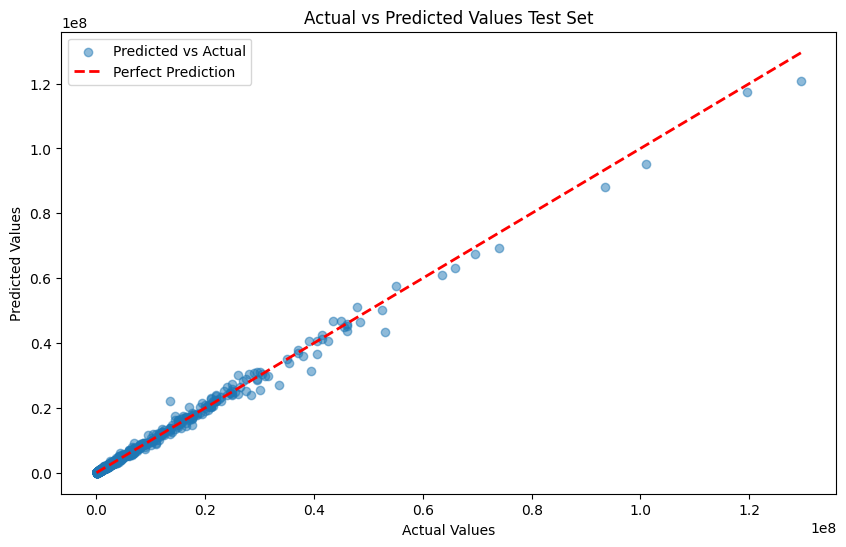

In [81]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Test Set")
plt.legend()
plt.show()

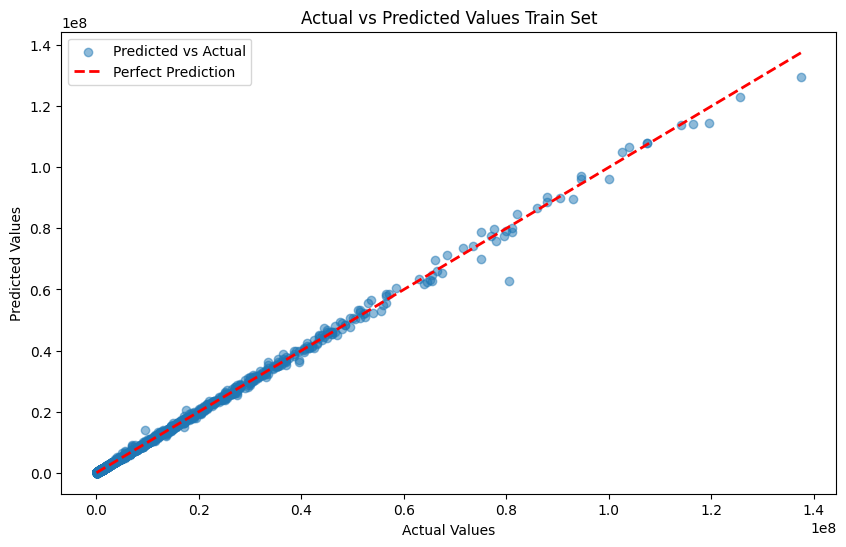

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, train_preds, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values Train Set")
plt.legend()
plt.show()

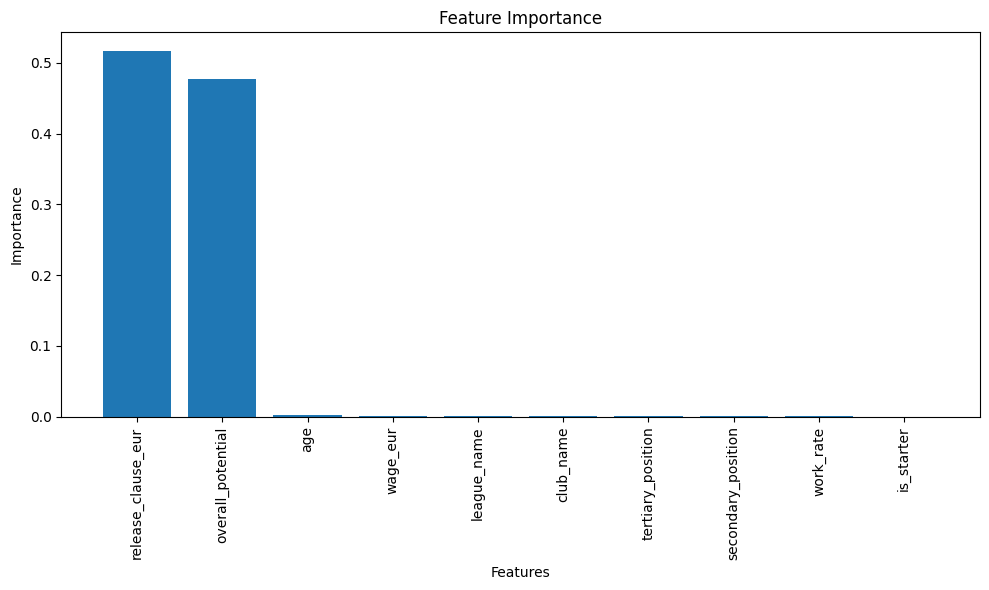

In [83]:
# Get feature importance
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort feature importance in descending order
sorted_indices = importances.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()